Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7628 - loss: 0.4945 - val_accuracy: 0.9116 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9300 - loss: 0.1917 - val_accuracy: 0.9179 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9460 - loss: 0.1419 - val_accuracy: 0.9368 - val_loss: 0.1847 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9476 - loss: 0.1283 - val_accuracy: 0.9326 - val_loss: 0.1821 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9585 - loss: 0.1035 - val_accuracy: 0.9558 - val_loss: 0.1437 - learning_rate: 0.0010
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9634 - loss: 0.0864 - val_accuracy: 0.9368 - val_loss: 0.1407 - learning_rate: 0.0010
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9712 - loss: 0.0735 - val_acc

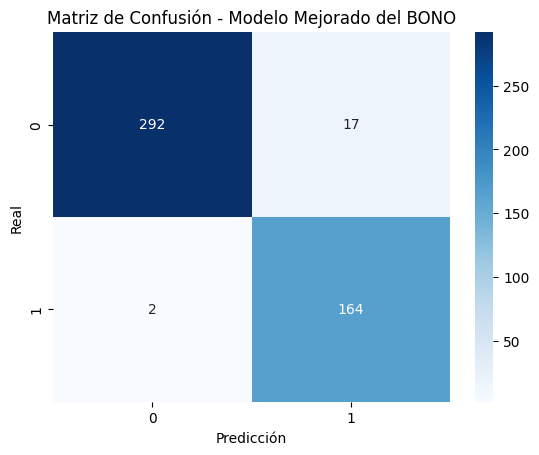

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Mejor vino según el modelo (mayor probabilidad de ser clase 5):

winery: Dehesa de Los Canonigos
year: 2015.0
rating: 4.2
num_reviews: 592
price: 35.09
body: 5.0
acidity: 3.0
country: Espana
region: Ribera del Duero
type: Ribera Del Duero Red

 Probabilidad predicha de ser clase 5: 1.0000


In [6]:
# Modelo optimizado para el BONO – F1-score máximo con arquitectura libre

# 1. Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 2. Cargar CSV local
df = pd.read_csv("wines_SPA.csv")  # Reemplaza con tu ruta local si lo necesitas

# 3. Filtrar clases 4 y 5
df = df[df['rating'].round().isin([4, 5])]

# 4. Limpieza y tratamiento de nulos
df = df.drop(columns=['wine'])
num_cols = ['year', 'price', 'num_reviews', 'body', 'acidity']
df[num_cols] = df[num_cols].replace("N.V.", pd.NA)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols + ['rating'])

# Guardar copia antes de transformación para mostrar datos legibles
df_original = df.copy()

# 5. Rebalanceo mejorado
df['rating_class'] = df['rating'].round().astype(int)
df_5 = df[df['rating_class'] == 5]
df_5 = pd.concat([df_5] * 5, ignore_index=True)  # Reforzamos clase 5
df_4 = df[df['rating_class'] == 4].sample(n=len(df_5), random_state=42)
df = pd.concat([df_4, df_5], ignore_index=True)

# 6. Tratamiento de outliers
def eliminar_outliers_iqr(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df = eliminar_outliers_iqr(df, ['price', 'num_reviews', 'body', 'acidity'])

# 7. Codificación y normalización
df = pd.get_dummies(df, columns=['winery', 'country', 'region', 'type'], drop_first=True)
df[num_cols] = df[num_cols].astype('float64')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 8. División del dataset
X = df.drop(columns=['rating', 'rating_class'])
y = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train - 4, num_classes=2)
y_test_cat = to_categorical(y_test - 4, num_classes=2)

# 9. Modelo optimizado – arquitectura profunda
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 10. Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 11. Entrenamiento
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 12. Evaluación con ajuste de umbral
y_pred = model.predict(X_test)
y_pred_labels = (y_pred[:,1] > 0.45).astype(int) + 4
y_true_labels = np.argmax(y_test_cat, axis=1) + 4

print("== Resultados del Modelo Mejorado para el BONO ==")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo Mejorado del BONO")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MEJOR VINO SEGÚN EL MODELO ===

# Predicciones para todo el dataset (usando modelo final)
y_all_pred = model.predict(X)
probs_clase_5 = y_all_pred[:, 1]

# Índice del vino con mayor probabilidad de ser clase 5
indice_mejor_vino = np.argmax(probs_clase_5)
mejor_vino = df_original.iloc[indice_mejor_vino]

# Mostrar columnas clave de forma limpia
print("\n Mejor vino según el modelo (mayor probabilidad de ser clase 5):\n")
for col, val in mejor_vino[['winery', 'year', 'rating', 'num_reviews', 'price', 'body', 'acidity', 'country', 'region', 'type']].items():
    print(f"{col}: {val}")

print(f"\n Probabilidad predicha de ser clase 5: {probs_clase_5[indice_mejor_vino]:.4f}")
